In [2]:
# imports 
import torch
from torch import nn
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.figure(0,figsize=(10,10))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

# generator / discriminator set up
class Generator1(nn.Module):
    def __init__(self, image_nc=1,ngf = 18):
        super(Generator1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1, 0)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5)


        self.fc1 = nn.Linear(16 * 8 * 8, 120) 
        self.fc2 = nn.Linear(120, 84)  
        self.fc3 = nn.Linear(84,128)

        self.c3 = nn.ConvTranspose2d(128, ngf * 8, 4, 1, 0, bias=False)
        self.norm3 = nn.BatchNorm2d(ngf * 8)
        self.c2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.norm2 = nn.BatchNorm2d(ngf * 4)
        self.c1 = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 1, 0, bias=False)
        self.norm1 = nn.BatchNorm2d(ngf * 2)
        self.c0 = nn.ConvTranspose2d( ngf * 2, ngf, 4, 1, 0, bias=False)
        self.norm0 = nn.BatchNorm2d(ngf)
        self.c = nn.ConvTranspose2d( ngf, image_nc, 4, 2, 1, bias=False)

    def forward(self,x):
        leaky_relu = nn.LeakyReLU(.2)
        relu = nn.ReLU()
        tanh = nn.Tanh()
        # convolution part
        x = leaky_relu(self.pool(self.conv1(x)))
        x = leaky_relu(self.conv2(x))
        x = x.view(-1, 16 * 8 * 8)
        # linear part
        x = leaky_relu(self.fc1(x))
        x = leaky_relu(self.fc2(x))
        x = leaky_relu(self.fc3(x))
        x = x.reshape(x.shape[0],x.shape[1],1,1)
        # transpose conv part
        x = relu(self.norm3(self.c3(x)))
        x = relu(self.norm2(self.c2(x)))
        x = relu(self.norm1(self.c1(x)))
        x = relu(self.norm0(self.c0(x)))
        x = tanh(self.c(x))
        return x
    
class Generator2(nn.Module):
    def __init__(self, image_nc=1,ngf = 18):
        super(Generator2, self).__init__()
        self.conv1 = nn.Conv2d(1,1,9)
        self.pool1 = nn.MaxPool2d(2,1) 
        self.conv2 = nn.Conv2d(1,1,7)
        self.pool2 = nn.MaxPool2d(2,1)

        self.fc1 = nn.Linear(144,100)
        self.fc2 = nn.Linear(100,64) 

        self.c2 = nn.ConvTranspose2d(1,1,7)
        self.norm2 = nn.BatchNorm2d(1)
        self.c1 = nn.ConvTranspose2d(1,1,11)
        self.norm1 = nn.BatchNorm2d(1)
        self.c0 = nn.ConvTranspose2d(1,1,5)

    def forward(self,x):
        leaky_relu = nn.LeakyReLU(.2)
        relu = nn.ReLU()
        tanh = nn.Tanh()
        # convolution part
        x = leaky_relu(self.pool1(self.conv1(x)))
        x = leaky_relu(self.pool2(self.conv2(x)))
        x = x.reshape(x.shape[0],x.shape[-1]**2)
        # linear part
        x = leaky_relu(self.fc1(x))
        x = leaky_relu(self.fc2(x))
        x = x.reshape(x.shape[0],1,8,8)
        # transpose conv part
        x = relu(self.norm2(self.c2(x)))
        x = relu(self.norm1(self.c1(x)))
        x = tanh(self.c0(x))
        return x
    
g1 = Generator1()
g2 = Generator2()

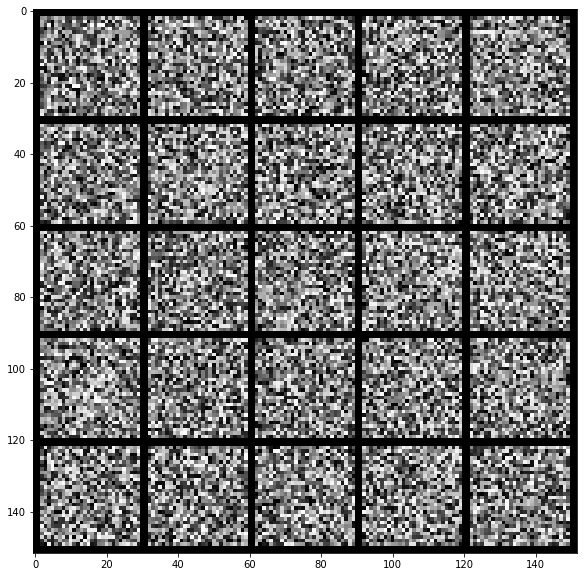

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


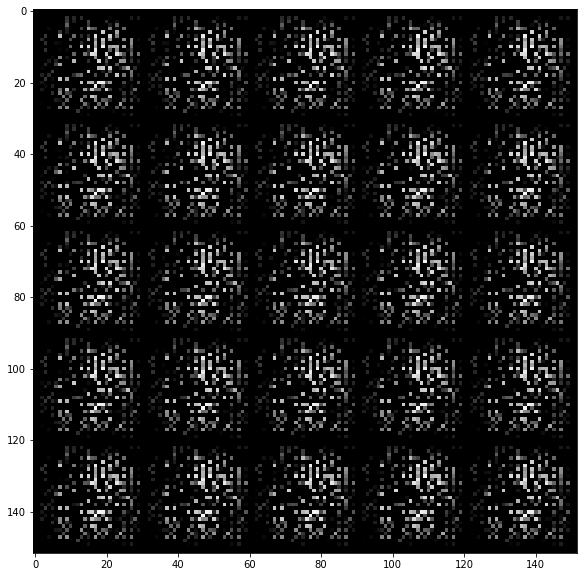

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


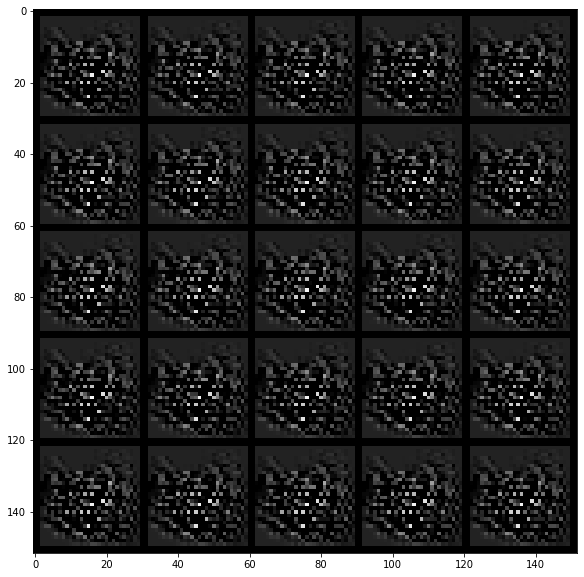

In [8]:
x = torch.rand(25,1,28,28)
show_tensor_images(x)
show_tensor_images(g1(x))
show_tensor_images(g2(x))

In [9]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.figure(0,figsize=(10,10))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

class Generator(nn.Module):
    def __init__(self, image_nc=1,ngf = 18):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(3,2,7)
        self.pool1 = nn.MaxPool2d(2,1) 
        self.conv2 = nn.Conv2d(2,1,7)
        self.pool2 = nn.MaxPool2d(2,1) 

        self.fc1 = nn.Linear(18*18,180) 
        self.fc2 = nn.Linear(180,100)  

        self.c3 = nn.ConvTranspose2d(1,2,7)
        self.norm3 = nn.BatchNorm2d(2)
        self.c2 = nn.ConvTranspose2d(2,3,7)
        self.norm2 = nn.BatchNorm2d(3)
        self.c1 = nn.ConvTranspose2d(3,3,7)
        self.norm1 = nn.BatchNorm2d(3)
        self.c0 = nn.ConvTranspose2d(3,3,5)

    def forward(self,x):
        leaky_relu = nn.LeakyReLU(.2)
        relu = nn.ReLU()
        tanh = nn.Tanh()
        # convolution part
        x = leaky_relu(self.pool1(self.conv1(x)))
        x = leaky_relu(self.pool2(self.conv2(x)))
        x = x.reshape(x.shape[0],x.shape[-1]**2)
        # linear part
        x = leaky_relu(self.fc1(x))
        x = leaky_relu(self.fc2(x))
        x = x.reshape(x.shape[0],1,10,10)
        # transpose conv part
        x = relu(self.norm3(self.c3(x)))
        x = relu(self.norm2(self.c2(x)))
        x = relu(self.norm1(self.c1(x)))
        x = tanh(self.c0(x))
        return x

g3 = Generator()

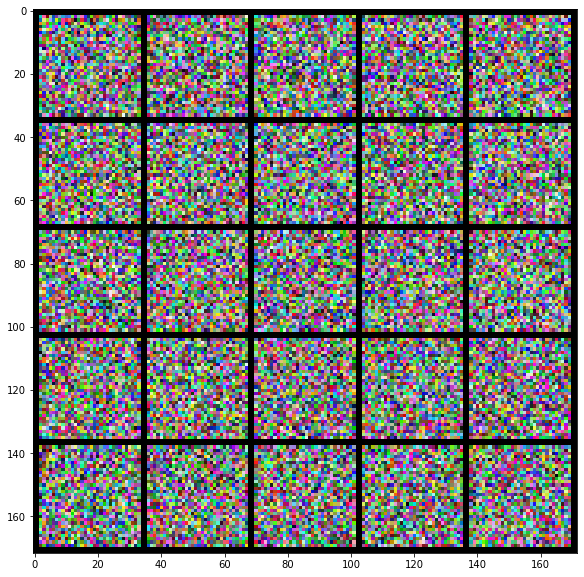

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


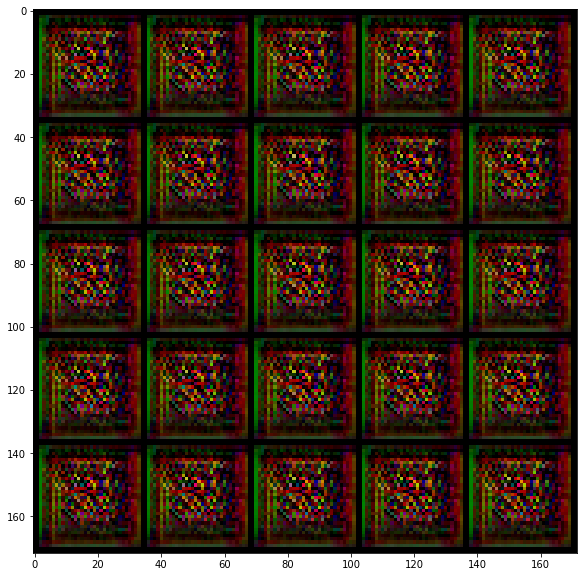

In [10]:
x = torch.rand(25,3,32,32)
show_tensor_images(x)
show_tensor_images(g3(x))

In [33]:
x = torch.rand(25,3,28,28)
torch.mean(torch.norm(torch.norm(x,dim=(2,3)),dim=1))

tensor(28.0049)

In [51]:
class Generator(nn.Module):
    def __init__(self, image_nc=1,ngf = 18):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1,8,kernel_size=4,stride=2,padding=1,bias=True)
        self.norm1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8,16,kernel_size=4,stride=2,padding=1,bias=True)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,32,kernel_size=2,stride=2,padding=1,bias=True)
        self.norm3 = nn.BatchNorm2d(32)

        self.convt1 = nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,bias=False)
        self.normt1 = nn.BatchNorm2d(16)
        self.convt2 = nn.ConvTranspose2d(16,8,kernel_size=4,stride=2,padding=1,bias=False)
        self.normt2 = nn.BatchNorm2d(8)
        self.convt3 = nn.ConvTranspose2d(8,1,kernel_size=4,stride=2,padding=1,bias=False)
        self.normt3 = nn.BatchNorm2d(1)

    def forward(self,x):
        relu = nn.ReLU()
        tanh = nn.Tanh()
        
        x = relu(self.norm1(self.conv1(x)))
        x = relu(self.norm2(self.conv2(x)))
        x = relu(self.norm3(self.conv3(x)))
        x = relu(self.normt1(self.convt1(x)))
        x = relu(self.normt2(self.convt2(x)))
        x = tanh(self.normt3(self.convt3(x)))
        return x

class Discriminator(nn.Module):
    def __init__(self, image_nc=1):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1,8,kernel_size=4,stride=2,padding=1,bias=True)
        self.norm1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8,16,kernel_size=3,stride=2,padding=1,bias=True)
        self.norm2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,8,kernel_size=3,stride=2,padding=1,bias=True)
        self.norm3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8,4,kernel_size=3,stride=2,padding=1,bias=True)
        self.norm4 = nn.BatchNorm2d(4)
        self.conv5 = nn.Conv2d(4,1,kernel_size=3,stride=2,padding=1,bias=True)
        self.norm5 = nn.BatchNorm2d(1)

    def forward(self, x):
        leaky_relu = nn.LeakyReLU(.2)
        sigmoid = nn.Sigmoid()
        x = leaky_relu(self.norm1(self.conv1(x)))
        x = leaky_relu(self.norm2(self.conv2(x)))
        x = leaky_relu(self.norm3(self.conv3(x)))
        x = leaky_relu(self.norm4(self.conv4(x)))
        x = sigmoid(self.norm5(self.conv5(x)))
        x = x.reshape(x.shape[0],)
        return x
    
g = Generator()
d = Discriminator()

In [54]:
images = torch.rand(10,1,28,28)
x = images


torch.Size([10])